In [1]:
#coding=utf-8 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,learning_curve,validation_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc  


df1 = pd.read_csv("D:\桌面\comparision-sample-list.csv")
df2 = pd.read_csv("D:\桌面\comparision-sample.csv",encoding='GB18030')
factor = pd.DataFrame()

print(df2.shape)
print(df1.iloc[84][0])

(75879, 77)
C600667


In [2]:
for i in df1.index:
    index = df2.loc[(df2.上市公司代码_Comcd == df1.loc[i][0])&(df2.日期_Date == df1.loc[i][1])].index[0]
    if df1.loc[i][2] == 1:
        if i == 0:
            black_estimate = df2.loc[index-120:index-31]
            black_window = df2.loc[index-30:index+29]
        else:
            black_estimate = pd.concat([black_estimate,df2.loc[index-120:index-31]],ignore_index=True)
            black_window = pd.concat([black_window,df2.loc[index-30:index+29]],ignore_index=True)
    else:
        if i == 1:
            white_estimate = df2.loc[index-120:index-31]
            white_window = df2.loc[index-30:index+29]
        else:
            white_estimate = pd.concat([white_estimate,df2.loc[index-120:index-31]],ignore_index=True)
            white_window = pd.concat([white_window,df2.loc[index-30:index+29]],ignore_index=True)
        
black_estimate.dropna(axis='index', how='any', subset=['流通市值加权平均市场日收益率_Drettmv','日收益率_Dret'],inplace = True)
white_estimate.dropna(axis='index', how='any', subset=['流通市值加权平均市场日收益率_Drettmv','日收益率_Dret'],inplace = True)
black_window.dropna(axis='index', how='any', subset=['流通市值加权平均市场日收益率_Drettmv','日收益率_Dret'],inplace = True)
white_window.dropna(axis='index', how='any', subset=['流通市值加权平均市场日收益率_Drettmv','日收益率_Dret'],inplace = True)
#black_estimate['流通市值加权平均市场日收益率_Drettmv'].fillna(0,inplace=True)
#black_estimate['日收益率_Dret'].fillna(0,inplace=True)
#black_window['流通市值加权平均市场日收益率_Drettmv'].fillna(0,inplace=True)
#black_window['日收益率_Dret'].fillna(0,inplace=True)
print(black_estimate.上市公司代码_Comcd)
print(black_window.shape)
print(white_estimate.shape)
print(white_window.shape)
#black_estimate.to_csv('black_estimate.csv',encoding='GB18030')

0       C600984
1       C600984
2       C600984
3       C600984
4       C600984
         ...   
3415    C002200
3416    C002200
3417    C002200
3418    C002200
3419    C002200
Name: 上市公司代码_Comcd, Length: 3269, dtype: object
(1719, 77)
(6133, 77)
(4045, 77)


In [3]:
def factor_extract(estimate,window,df1,sample):
    factor = pd.DataFrame()
    car = []
    day_return = []
    amp_day_return = []
    amp_car = []
    beta = []
    std = []
    transaction = []
    turnover_rate = []
    eps = []
    roe = []
    naps = []

    for i in df1.index:
        regression = estimate.loc[(estimate.上市公司代码_Comcd == df1.loc[i][0])&(df1.loc[i][2] == sample)]
        predict = window.loc[(window.上市公司代码_Comcd == df1.loc[i][0])&(df1.loc[i][2] == sample)]
    
        x_train = regression.流通市值加权平均市场日收益率_Drettmv
        y_train = regression.日收益率_Dret
        if x_train.isnull().all() or y_train.isnull().all():
            #print(df1.iloc[i][0])
            continue
        else:
            x_train = np.array(x_train).reshape(-1,1)
            x_test = predict.流通市值加权平均市场日收益率_Drettmv
            x_test = np.array(x_test).reshape(-1,1)
            y_test = predict.日收益率_Dret
    
            linreg = LinearRegression()
            linreg.fit(x_train, y_train)
    
    
        #beta = linreg.coef_ #beta系数
    
    
            y_pred = linreg.predict(x_test)
    
            car.append(sum(y_test-y_pred))# Cumulative Abnormal Return
            day_return.append(y_test.mean())# Daily Return 
            amp_day_return.append(max(y_test)-min(y_test))# Amplitude of Daily Returnsn
            amp_car.append(max(y_test-y_pred)-min(y_test-y_pred))#Cumulative Amplitude of Daily Returns
            beta.append(list(linreg.coef_)[0])#Beta
            std.append(y_test.std())# Standard Deviation of Daily Return
            transaction.append(predict.成交量_Trdvol.mean()/regression.成交量_Trdvol.mean())# Transaction
            turnover_rate.append(predict.总股数日换手率_DFulTurnR.mean()/100)# Turnover Rate
            eps.append(predict['每股收益(摊薄)(元/股)_EPS'].mean()) #EPS
            roe.append(predict['净资产收益率(摊薄)_ROE'].mean()) #ROE
            naps.append(predict['每股净资产(元/股)_NAPS'].mean()) #NAPS
    
       
    Car = np.asarray(car)
    Day_Return = np.asarray(day_return)
    Amp_Day_Return = np.asarray(day_return)
    Amp_Car = np.asarray(amp_car)
    Beta = np.asarray(beta)
    Std = np.asarray(std)
    Transaction = np.asarray(transaction)
    Turnover_Rate = np.asarray(turnover_rate)
    Eps = np.asarray(eps)
    Roe = np.asarray(roe)
    Naps = np.asarray(naps)


    #factor['Number'] = df1.Number
    factor['Car'] = Car
    factor['Amp_Car'] = Amp_Car
    factor['Day_Return'] = Day_Return
    #factor['Amp_Day_Return'] = Amp_Day_Return
    #factor['Transaction'] = Transaction
    #factor['Turnover_Rate'] = Turnover_Rate
    factor['Std'] = Std
    factor['Beta'] = Beta
    factor['Eps'] = Eps
    factor['Roe'] = Roe
    factor['Naps'] = Naps
    #factor['Target'] = df1.Inside_trade
    return factor

In [4]:
black_factor = factor_extract(black_estimate,black_window,df1,1)

In [5]:
white_factor = factor_extract(white_estimate,white_window,df1,0)

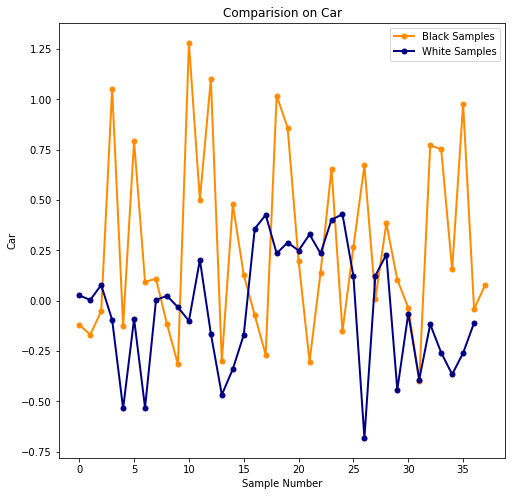

In [6]:
plt.figure(figsize=(8,8))
lw = 2
plt.plot(black_factor.index,black_factor.Car,color='darkorange',lw = lw, label = 'Black Samples',
         marker = 'o',markerfacecolor = 'darkorange',markersize = 5)
plt.plot(white_factor.index[0:37],white_factor.Car[0:37],color='navy',lw = lw, label = 'White Samples',
        marker = 'o',markerfacecolor = 'navy',markersize = 5)
plt.xlabel('Sample Number')
plt.ylabel('Car')
plt.title('Comparision on Car')
plt.legend()

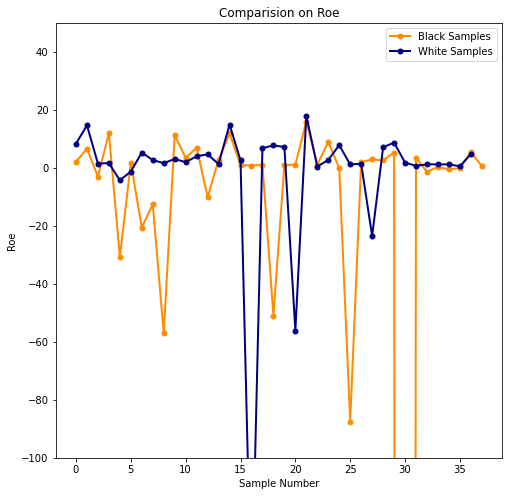

In [7]:
plt.figure(figsize=(8,8))
lw = 2
plt.plot(black_factor.index,black_factor.Roe,color='darkorange',lw = lw, label = 'Black Samples',
         marker = 'o',markerfacecolor = 'darkorange',markersize = 5)
plt.plot(white_factor.index[0:37],white_factor.Roe[0:37],color='navy',lw = lw, label = 'White Samples',
        marker = 'o',markerfacecolor = 'navy',markersize = 5)
plt.ylim([-100, 50])
plt.xlabel('Sample Number')
plt.ylabel('Roe')
plt.title('Comparision on Roe')
plt.legend()

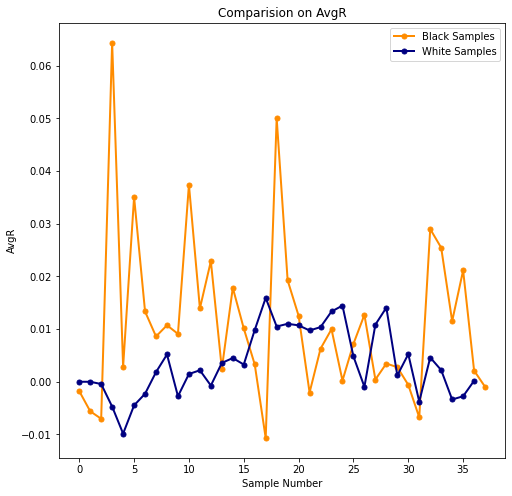

In [8]:
plt.figure(figsize=(8,8))
lw = 2
plt.plot(black_factor.index,black_factor.Day_Return,color='darkorange',lw = lw, label = 'Black Samples',
         marker = 'o',markerfacecolor = 'darkorange',markersize = 5)
plt.plot(white_factor.index[0:37],white_factor.Day_Return[0:37],color='navy',lw = lw, label = 'White Samples',
        marker = 'o',markerfacecolor = 'navy',markersize = 5)
plt.xlabel('Sample Number')
plt.ylabel('AvgR')
plt.title('Comparision on AvgR')
plt.legend()